
# Jupyter Notebook Technical Analysis Demo
Data-set URL: https://raw.githubusercontent.com/iamnewneo/ML_For_Trading/master/data/stocks/XOM.csv

Let's import some packages that will be helpful for us:

In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

## Preparing and visualing our dataset 

Now we can write a couple of functions to help find our dataset, read it in, and clean it, all for our date range.

In [2]:
def ticker_to_path(ticker, base_dir="data"):
    """Return CSV file path for given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(ticker, dates):
    """Read in daily price(adjusted close) of asset from CSV files for a given set of dates."""
    df = pd.DataFrame(index=dates)
    df_temp = pd.read_csv('https://raw.githubusercontent.com/iamnewneo/ML_For_Trading/master/data/stocks/XOM.csv', index_col='Date', parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])# Read in entire data file.
    df = df.join(df_temp, how='inner') # Merge data-frames, setting specified data range as index.
    df['Adj Close'].fillna(method='ffill', inplace=True)# Make sure data is nice and clean with no missing values.
    return df


Below we can call these functions to get an idea of what our series looks like at this point.

In [3]:
dates = pd.date_range('2012-01-01', '2013-09-10')
symbol = 'XOM'
data = get_data(symbol, dates)
data.head()
    


,Adj Close
2012-01-03,84.40
2012-01-04,84.42
2012-01-05,84.16
2012-01-06,83.53
2012-01-09,83.91


Next let's define a simple fcn so we can start visualizing our data.

In [4]:
def plot_data(df,ticker,date_range):
    sns.set_style("darkgrid")
    ax = df.plot(title = '{} Price'.format(ticker), figsize=(12,6))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.tick_params(labelsize=10)   
    plt.show()



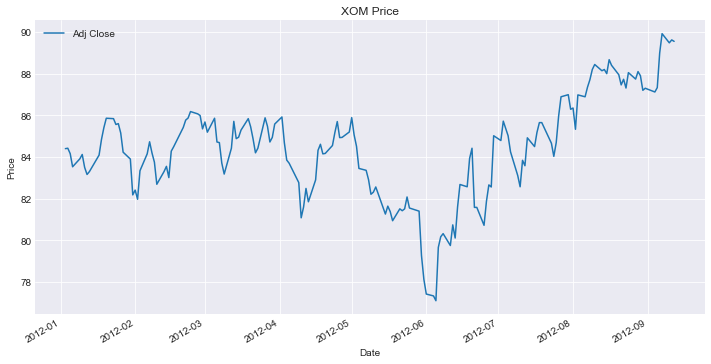

In [5]:
plot_data(data, symbol, dates)

## Plotting data with technical indicators

Next, I am curious to see if this historical data can help us build a trading strategy for this stock in the future. We can start by defining a couple fcns that will add columns to our dataframe.

In [6]:
def rolling_mean(series, window):
    """Returns a rolling mean series."""
    return series.rolling(window = window).mean()

def rolling_standard_deviation(series, window):
    """Returns a rolling mean series."""
    return series.rolling(window = window).std()

def exponential_moving_avg(series, span):
    """Returns an exponential rolling mean. Same as a rolling mean but it weights recent observations more heavily, which results in an indicator that reacts faster to price changes."""
    return series.ewm(span=span).mean()

def get_upperband(rm,std):
    "Returns a upper band that runs two sd's above the rolling mean. Is a helpful technical indicator because,\
for approximately normally distributed data, roughly 42.5/50 percent of the total observations above the mean will be\
in this range. This works well as a sell signal. In this case, we will be using it as a buy stop order"
    upper_band = rm + std*2
    return upper_band

def get_lowerband(rm,std):
    "Returns a lower band that runs two sd's below the rolling mean. Is a helpful technical indicator because,\
for approximately normally distributed data, roughly 42.5/50 percent of the total observations below the mean will be\
in this range. This works well as a buy signal. In this case, we will be using it as a sell stop order"
    lower_band = rm - std*2
    return lower_band


I will now add a couple different columns to our dataframe and plot them.

In [7]:
data['RollingMean'] = rolling_mean(data['Adj Close'], 30)
print(data.head())

            Adj Close  RollingMean
2012-01-03      84.40          NaN
2012-01-04      84.42          NaN
2012-01-05      84.16          NaN
2012-01-06      83.53          NaN
2012-01-09      83.91          NaN


plot_data(data, symbol, dates)

Next let's add columns that contain data for Bollinger Bands set 2 standard deviations above and below our 30 day rolling mean, and plot the new df.

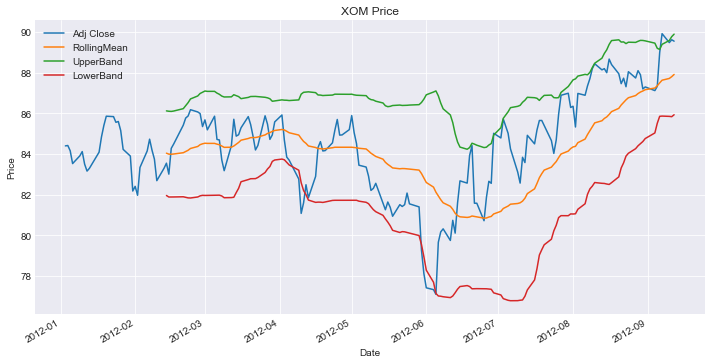

In [8]:
data['UpperBand'] = get_upperband(data['RollingMean'], rolling_standard_deviation(data['Adj Close'], 30))
data['LowerBand'] = get_lowerband(data['RollingMean'], rolling_standard_deviation(data['Adj Close'], 30))
plot_data(data, symbol, dates)

As we can see above, for our date range the Bollinger Bands fit the peaks and valleys of this stock's price very well. Assuming the historical data is indicative of the stock's price in the future, we could develop a simple strategy to go long when the price reaches the lower band, and to go short when the price reaches the top band. This is a nice start, but let's see if adding one more indicator will improve our strategy. 

Let's try adding a moving average convergence divergence indicator. MACD is a trend-following momentum indicator that shows the relationship between two moving averages as they converge/diverge. We calculate the MACD by subtracting a 12 day EMA from a 26 day EMA. We will want to track the MACD against a signal line, which we calculate by taking a simple rolling mean of the MACD with a window of 9 days. Let's calculate and plot these new indicators and see if they are helpful for us here.


In [9]:
data['12 EMA'] = exponential_moving_avg(data['Adj Close'], 12)
data['26 EMA'] = exponential_moving_avg(data['Adj Close'], 26)
data['MACD'] = (data['12 EMA'] - data['26 EMA'])
data['SignalLine'] = rolling_mean(data['MACD'], 7)# typically we would use a 9 day window, but through trial and error found 7 works better here.
data.tail()#might as well take a look at a few rows of our df


,Adj Close,RollingMean,UpperBand,LowerBand,12 EMA,26 EMA,MACD,SignalLine
2012-09-06,88.99,87.499000,89.143513,85.854487,87.751998,87.318065,0.433933,0.496860
2012-09-07,89.92,87.631000,89.395675,85.866325,88.085537,87.510801,0.574736,0.482769
2012-09-10,89.48,87.717333,89.582557,85.852109,88.300070,87.656668,0.643402,0.484234
2012-09-11,89.62,87.805000,89.773152,85.836848,88.503136,87.802100,0.701036,0.507441
2012-09-12,89.55,87.913667,89.895630,85.931703,88.664192,87.931574,0.732617,0.545482


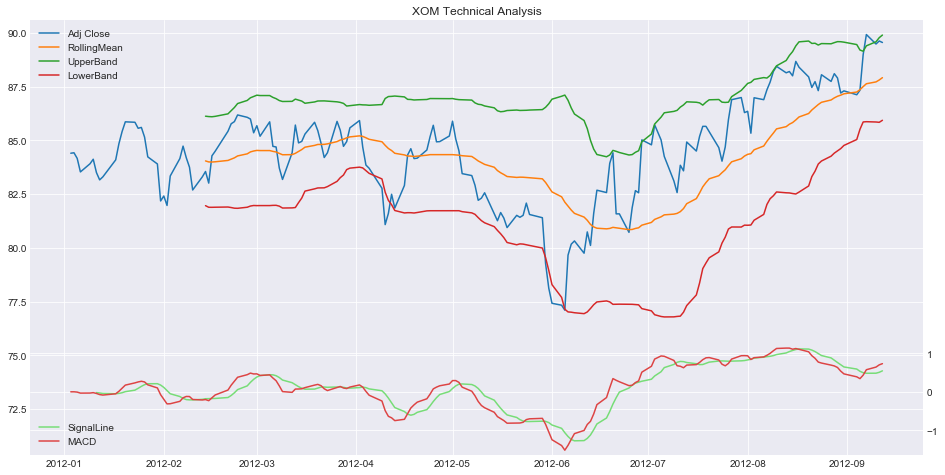

In [10]:
def plot_BB_and_RM_and_MACD(df, ticker):
    """Plots asset price, bollinger bands, rolling mean, moving average convergence divergence, and signal line, on one graph."""
    sns.set_style("darkgrid")
    fig, ax1 = plt.subplots(figsize=(16, 8))#create subplots
    ax1.plot(df[['Adj Close', 'RollingMean', 'UpperBand', 'LowerBand']])#plot these columns from df
    y = ax1.get_ylim()
    ax1.set_ylim(y[0] - (y[1] - y[0]) * .4, y[1])# make top graph is clear
    ax2 = ax1.twinx()# create plot for MACD
    ax2.set_position(matplotlib.transforms.Bbox([[0.125, 0.125], [0.9, 0.32]]))# position plot correctly
    ax2.plot(df['SignalLine'], color='#77dd77')
    ax2.plot(df['MACD'], color='#dd4444')
    ax1.set_title('{} Technical Analysis'.format(symbol))
    ax1.legend(['Adj Close', 'RollingMean', 'UpperBand', 'LowerBand'], loc='upper left')
    ax2.legend(['SignalLine', 'MACD'], loc='lower left')
    plt.show()
    
plot_BB_and_RM_and_MACD(data, symbol)



Now that we have all of our indicators let us consider a simple trading strategy.

     -Go long when MACD crosses above the signal line. Treat the upper band as a buy stop order, until the MACD crosses or touches the signal line and moves above it, at which point you go long again.
    
     -Go short when MACD crosses below the signal line. Treat the lower band as a sell stop order, until the MACD crosses or touches the signal line and moves below it, at which point you short again.

If we look at this plot above, it is easy to see that if we were trading our strategy for XOM in this window of time we would have made a nice profit.


## Setting buy/sell signals and calculating profit
    
Next we should create some columns in our dataframe that contain buy/sell signals derived from our trading strategy.

In [11]:
data['Buy'] = 0
data['Sell'] = 0
data['Gains'] = 0


Below we have code for a simplied version of our previously mentioned trading strategy. We create a buy signal in our new 'Buy' column whenever the MACD indicator above it's signal line, and we create a sell signal in our 'Sell' column whenever the MACD indicator crosses below it's signal line.

In [12]:
data.loc[data['MACD'] > data['SignalLine'], 'Buy'] = 1
data.loc[data['MACD'] < data['SignalLine'], 'Sell'] = -1

Let's plot the stock price and all of it's indicators, as well as the buy/sell signal columns. We can accomplish this with the following fcn.

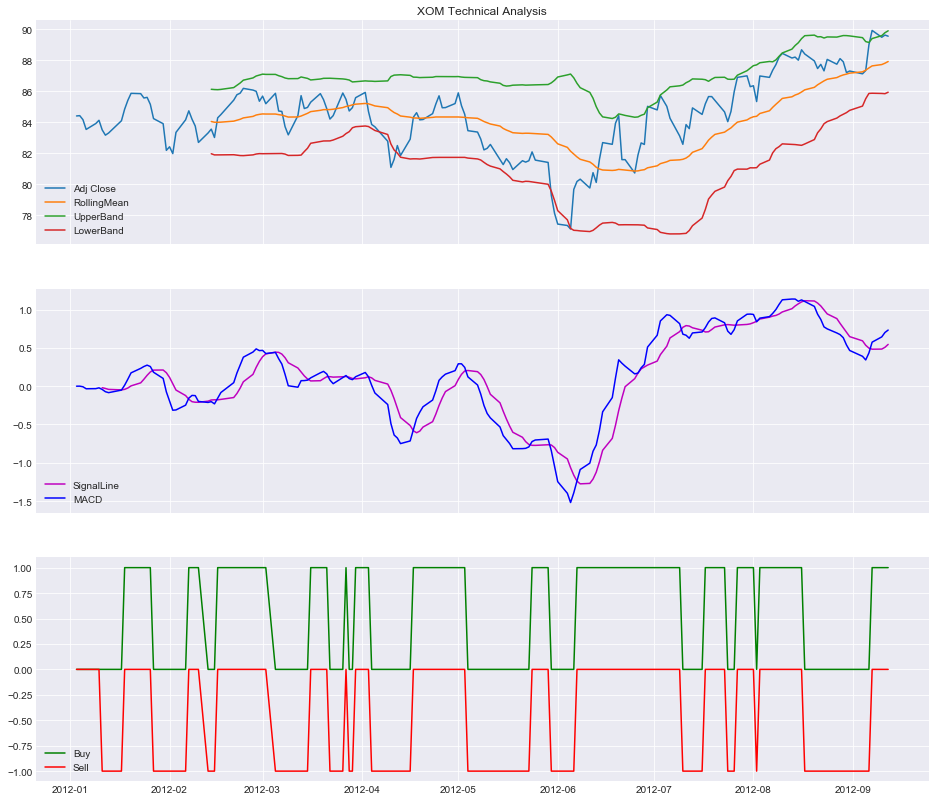

In [13]:
def plot_three(df,dates,title):
    fig,[ax1,ax2, ax3] = plt.subplots(3,1, sharex = True, figsize=(16,14))
    ax1.plot(df[['Adj Close', 'RollingMean', 'UpperBand', 'LowerBand']])
    
    ax2.plot(df['SignalLine'], color = 'm')
    ax2.plot(df['MACD'], color = 'b')

    ax3.plot(df['Buy'], color = 'g')
    ax3.plot(df['Sell'], color = 'r')

    ax1.legend(['Adj Close', 'RollingMean', 'UpperBand', 'LowerBand'], loc = 'lower left')
    ax2.legend(['SignalLine', 'MACD'], loc = 'lower left')
    ax3.legend(['Buy', 'Sell'], loc = 'lower left')
    ax1.set_title(title)
    plt.show()
    
plot_three(data,dates,'{} Technical Analysis'.format(symbol))

In [14]:
pd.options.mode.chained_assignment = None

for i in range(1, len(data)):
    if data['Buy'].iloc[i] == 1:
        data['Gains'].iloc[i] = data['Adj Close'].iloc[i] - data['Adj Close'].iloc[i-1]
    elif data['Sell'].iloc[i] == -1:
        data['Gains'].iloc[i] = - (data['Adj Close'].iloc[i] - data['Adj Close'].iloc[i-1])

total_gains = data['Gains'].sum()
print(total_gains)
        

15.45
